## Parse the data

In [14]:
# ============================================================
# STEP 1: Load GTFS Data & Explore
# Kochi Metro (KMRL) Last-Mile & Service Risk Analysis
# ============================================================

import pandas as pd
import os

root = 'KMRLOpenData'

# --- Load all relevant GTFS files ---
stops      = pd.read_csv(f'{root}/stops.txt')
routes     = pd.read_csv(f'{root}/routes.txt')
trips      = pd.read_csv(f'{root}/trips.txt')
stop_times = pd.read_csv(f'{root}/stop_times.txt')
calendar   = pd.read_csv(f'{root}/calendar.txt')

print("=== STOPS ===")
print(stops.shape)
display(stops.head(3))

print("\n=== ROUTES ===")
print(routes.shape)
display(routes.head(3))

print("\n=== TRIPS ===")
print(trips.shape)
display(trips.head(3))

print("\n=== STOP_TIMES ===")
print(stop_times.shape)
display(stop_times.head(3))

print("\n=== CALENDAR ===")
display(calendar)

=== STOPS ===
(25, 8)


,stop_id,stop_lat,stop_lon,stop_name,stop_desc,location_type,zone_id,wheelchair_boarding
0,ALVA,10.1099,76.3495,Aluva,NaN,0,ALVA,1
1,PNCU,10.0951,76.3466,Pulinchodu,NaN,0,PNCU,1
2,CPPY,10.0873,76.3428,Companypady,NaN,0,CPPY,1



=== ROUTES ===
(1, 5)


,route_id,route_short_name,route_long_name,route_type,agency_id
0,R1,KMRL,Kochi Metro Route 1,1,KMRL



=== TRIPS ===
(450, 5)


,route_id,service_id,trip_id,direction_id,shape_id
0,R1,WK,WK_1,0,R1_0
1,R1,WK,WK_2,1,R1_1
2,R1,WK,WK_22,0,R1_0



=== STOP_TIMES ===
(10726, 7)


,trip_id,stop_sequence,stop_id,arrival_time,departure_time,timepoint,shape_dist_traveled
0,WE_1,1,TPHT,22:50:19,22:52:41,1,0.00
1,WE_1,2,SNJN,22:54:30,22:54:45,1,0.99
2,WE_1,3,VAKK,22:56:08,22:56:23,1,1.72



=== CALENDAR ===


,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,WK,1,1,1,1,1,1,0,20240812,20251231
1,WE,0,0,0,0,0,0,1,20240812,20251231


In [15]:
# ============================================================
# STEP 2 (revised): Headway Analysis & Passenger Wait Risk
# ============================================================

import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# --- Service hours assumption: KMRL runs ~18 hrs/day (6am-midnight) ---
SERVICE_HOURS = 18
SERVICE_MINUTES = SERVICE_HOURS * 60  # 1080 minutes

# --- Count weekday trips per stop ---
weekday_trips = trips[trips['service_id'] == 'WK']['trip_id']
weekday_stop_times = stop_times[stop_times['trip_id'].isin(weekday_trips)]

trips_per_stop = (
    weekday_stop_times
    .groupby('stop_id')['trip_id']
    .nunique()
    .reset_index()
    .rename(columns={'trip_id': 'weekday_trips'})
)

# --- Calculate average headway (minutes between trains) ---
# Each stop serves both directions, so divide trips by 2 for one direction
trips_per_stop['one_direction_trips'] = trips_per_stop['weekday_trips'] // 2
trips_per_stop['avg_headway_min'] = (SERVICE_MINUTES / trips_per_stop['one_direction_trips']).round(1)

# --- Merge with stop metadata ---
stops_freq = stops.merge(trips_per_stop, on='stop_id', how='left')

# --- Risk: headway > 8 min = poor frequency by urban transit standards ---
def classify_risk(h):
    if h > 10:
        return 'High Risk'
    elif h > 7:
        return 'Medium Risk'
    else:
        return 'Low Risk'

stops_freq['risk'] = stops_freq['avg_headway_min'].apply(classify_risk)

print("Headway stats:")
display(stops_freq[['stop_name', 'weekday_trips', 'one_direction_trips', 'avg_headway_min', 'risk']]
        .sort_values('avg_headway_min', ascending=False))

print("\nRisk distribution:")
print(stops_freq['risk'].value_counts())

Headway stats:


,stop_name,weekday_trips,one_direction_trips,avg_headway_min,risk
21,Pettah,240,120,9.0,Medium Risk
23,SN Junction,240,120,9.0,Medium Risk
18,Elamkulam,240,120,9.0,Medium Risk
20,Thykoodam,240,120,9.0,Medium Risk
19,Vyttila,240,120,9.0,Medium Risk
24,Tripunithura,240,120,9.0,Medium Risk
22,Vadakkekotta,240,120,9.0,Medium Risk
6,Cochin University,242,121,8.9,Medium Risk
8,Edapally,242,121,8.9,Medium Risk
16,Ernakulam South,242,121,8.9,Medium Risk



Risk distribution:
risk
Medium Risk    25
Name: count, dtype: int64


In [16]:
# --- GeoDataFrame ---
geometry = [Point(lon, lat) for lon, lat in zip(stops_freq['stop_lon'], stops_freq['stop_lat'])]
gdf = gpd.GeoDataFrame(stops_freq, geometry=geometry, crs='EPSG:4326')
print("\nGeoDataFrame ready with", len(gdf), "stops")
print(gdf[['stop_name', 'weekday_trips', 'risk', 'geometry']].head())


GeoDataFrame ready with 25 stops
     stop_name  weekday_trips         risk                 geometry
0        Aluva            246  Medium Risk  POINT (76.3495 10.1099)
1   Pulinchodu            246  Medium Risk  POINT (76.3466 10.0951)
2  Companypady            246  Medium Risk  POINT (76.3428 10.0873)
3  Ambattukavu            246  Medium Risk  POINT (76.3389 10.0793)
4       Muttom            255  Medium Risk  POINT (76.3336 10.0727)


In [17]:
# ============================================================
# STEP 3: Interactive Folium Map
# ============================================================
import folium
from folium.plugins import MiniMap
import os

# --- Color mapping ---
risk_colors = {
    'High Risk':   'red',
    'Medium Risk': 'orange',
    'Low Risk':    'green'
}

# --- Base map centered on Kochi ---
m = folium.Map(
    location=[10.02, 76.31],
    zoom_start=12,
    tiles='CartoDB positron'
)

# --- Add each metro stop as a circle marker ---
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=10,
        color=risk_colors[row['risk']],
        fill=True,
        fill_color=risk_colors[row['risk']],
        fill_opacity=0.8,
        popup=folium.Popup(
            f"""
            <b>{row['stop_name']}</b><br>
            Weekday Trips: {row['weekday_trips']}<br>
            Trips (one direction): {row['one_direction_trips']}<br>
            Avg Headway: {row['avg_headway_min']} min<br>
            Risk Level: {row['risk']}
            """,
            max_width=200
        ),
        tooltip=f"{row['stop_name']} — {row['avg_headway_min']} min headway"
    ).add_to(m)

# --- Draw the metro line (connect stops in sequence order) ---
line_coords = stops_freq.sort_values('stop_id')[['stop_lat', 'stop_lon']].values.tolist()
folium.PolyLine(
    locations=line_coords,
    color='blue',
    weight=3,
    opacity=0.5,
    tooltip='KMRL Metro Line'
).add_to(m)

# --- City marker ---
folium.Marker(
    location=[10.02, 76.31],
    popup="Kochi, Kerala, India",
    tooltip="Kochi, Kerala, India",
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(m)

# --- Minimap inset (shows Kochi's location in India) ---
minimap = MiniMap(
    tile_layer='CartoDB positron',
    position='bottomright',
    width=150,
    height=150,
    collapsed_width=25,
    collapsed_height=25,
    zoom_level_offset=-7,
    toggle_display=True
)
m.add_child(minimap)

# --- Legend ---
legend_html = """
<div style="position: fixed; bottom: 40px; left: 40px; z-index: 1000;
     background-color: white; padding: 12px 16px; border-radius: 8px;
     border: 1px solid #ccc; font-family: Arial; font-size: 13px;">
  <b>Headway Risk Level</b><br>
  <i style="background:red;width:12px;height:12px;display:inline-block;border-radius:50%;margin-right:6px;"></i> High Risk (&gt;10 min)<br>
  <i style="background:orange;width:12px;height:12px;display:inline-block;border-radius:50%;margin-right:6px;"></i> Medium Risk (7–10 min)<br>
  <i style="background:green;width:12px;height:12px;display:inline-block;border-radius:50%;margin-right:6px;"></i> Low Risk (&lt;7 min)<br>
  <br>
  <small>Source: KMRL Open GTFS Data</small>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# --- Save & display ---
os.makedirs('output', exist_ok=True)
m.save('output/kochi_metro_headway_map.html')
print("Map saved to output/kochi_metro_headway_map.html")
m

Map saved to output/kochi_metro_headway_map.html


In [18]:
# ============================================================
# STEP 4: Summary Statistics & Export Findings
# ============================================================

# --- Summary stats ---
print("=" * 50)
print("KMRL SERVICE FREQUENCY ANALYSIS — SUMMARY")
print("=" * 50)
print(f"Total metro stops     : {len(gdf)}")
print(f"Total weekday trips   : {trips[trips['service_id'] == 'WK']['trip_id'].nunique()}")
print(f"Total weekend trips   : {trips[trips['service_id'] == 'WE']['trip_id'].nunique()}")
print(f"\nHeadway range         : {gdf['avg_headway_min'].min()} – {gdf['avg_headway_min'].max()} minutes")
print(f"Average headway       : {gdf['avg_headway_min'].mean():.1f} minutes")
print(f"\nUrban benchmark       : < 7 minutes (good frequency)")
print(f"KMRL status           : All stops ABOVE benchmark → Medium Risk")
print(f"\nRisk distribution:")
print(gdf['risk'].value_counts().to_string())
# --- Export to CSV ---
export_cols = ['stop_id', 'stop_name', 'stop_lat', 'stop_lon',
               'weekday_trips', 'one_direction_trips', 'avg_headway_min', 'risk']

gdf[export_cols].sort_values('avg_headway_min', ascending=False).to_csv(
    'output/kochi_metro_headway_analysis.csv', index=False
)

print("Findings saved to output/kochi_metro_headway_analysis.csv")

KMRL SERVICE FREQUENCY ANALYSIS — SUMMARY
Total metro stops     : 25
Total weekday trips   : 255
Total weekend trips   : 195

Headway range         : 8.5 – 9.0 minutes
Average headway       : 8.9 minutes

Urban benchmark       : < 7 minutes (good frequency)
KMRL status           : All stops ABOVE benchmark → Medium Risk

Risk distribution:
risk
Medium Risk    25
Findings saved to output/kochi_metro_headway_analysis.csv


## Adding bus/boat stops with metro lines

In [19]:
# ============================================================
# STEP A: Download & Explore Kochi Bus/Boat GTFS Data
# ============================================================
import requests, zipfile, io, os
import pandas as pd

# --- Download the zip ---
url = "https://jungle-bus.github.io/KochiTransport/KochiTransport.zip"
print("Downloading KochiTransport GTFS...")
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("KochiTransportData")
print("Done! Files extracted:")
print(os.listdir("KochiTransportData"))
# --- Load and explore ---
bus_stops  = pd.read_csv("KochiTransportData/stops.txt")
bus_routes = pd.read_csv("KochiTransportData/routes.txt")
bus_trips  = pd.read_csv("KochiTransportData/trips.txt")

print("=== BUS/BOAT STOPS ===")
print(f"Total stops: {bus_stops.shape[0]}")
display(bus_stops.head(3))

print("\n=== ROUTES ===")
print(f"Total routes: {bus_routes.shape[0]}")
print("\nRoute types:")
print(bus_routes['route_type'].value_counts())
# route_type: 3 = bus, 4 = ferry/boat
display(bus_routes.head(3))

print("\n=== TRIPS ===")
print(f"Total trips: {bus_trips.shape[0]}")

Done! Files extracted:
['stops.txt', 'frequencies.txt', 'shapes.txt', 'trips.txt', 'stop_times.txt', 'feed_info.txt', 'calendar.txt', 'routes.txt', 'agency.txt']
=== BUS/BOAT STOPS ===
Total stops: 3258


,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,n622522403,NaN,Sasthammugal,NaN,9.953119,76.389954,NaN,NaN,0,NaN,NaN,0
1,n622536423,NaN,Kuppethazham,NaN,9.939056,76.418507,NaN,NaN,0,NaN,NaN,0
2,n622536426,NaN,Kochangady,NaN,9.933728,76.423360,NaN,NaN,0,NaN,NaN,0



=== ROUTES ===
Total routes: 473

Route types:
route_type
3    465
4      8
Name: count, dtype: int64


,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,r10831465,Kochi city boat,NaN,Vypin ↔ Fort Kochi (Ro Ro),NaN,4,https://jungle-bus.github.io/unroll/route.html...,NaN,NaN
1,r10831516,Mofussil Kochi bus,NaN,High Court ↔ Nedungad (via Vypin),NaN,3,https://jungle-bus.github.io/unroll/route.html...,0000ff,ffffff
2,r10831517,Mofussil Kochi bus,NaN,Manjanakad ↔ High Court,NaN,3,https://jungle-bus.github.io/unroll/route.html...,0000ff,ffffff



=== TRIPS ===
Total trips: 933


In [20]:
# ============================================================
# STEP B: Create GeoDataFrames for Bus & Boat Stops
# ============================================================
import geopandas as gpd
from shapely.geometry import Point

# --- Separate bus and boat stops via routes → trips → stop_times ---
bus_stop_times = pd.read_csv("KochiTransportData/stop_times.txt")
bus_trips_df   = pd.read_csv("KochiTransportData/trips.txt")

# --- Tag each trip with its route type ---
trips_with_type = bus_trips_df.merge(
    bus_routes[['route_id', 'route_type']], on='route_id', how='left'
)

# --- Get stop_ids that are served by bus (3) and boat (4) ---
bus_trip_ids  = trips_with_type[trips_with_type['route_type'] == 3]['trip_id']
boat_trip_ids = trips_with_type[trips_with_type['route_type'] == 4]['trip_id']

bus_stop_ids  = bus_stop_times[bus_stop_times['trip_id'].isin(bus_trip_ids)]['stop_id'].unique()
boat_stop_ids = bus_stop_times[bus_stop_times['trip_id'].isin(boat_trip_ids)]['stop_id'].unique()

# --- Filter stops ---
bus_stops_only  = bus_stops[bus_stops['stop_id'].isin(bus_stop_ids)].copy()
boat_stops_only = bus_stops[bus_stops['stop_id'].isin(boat_stop_ids)].copy()

print(f"Bus stops  : {len(bus_stops_only)}")
print(f"Boat stops : {len(boat_stops_only)}")

Bus stops  : 3228
Boat stops : 30


In [21]:
# --- Create GeoDataFrames ---
def make_gdf(df):
    geometry = [Point(lon, lat) for lon, lat in zip(df['stop_lon'], df['stop_lat'])]
    return gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

bus_gdf  = make_gdf(bus_stops_only)
boat_gdf = make_gdf(boat_stops_only)

print("Bus GeoDataFrame:")
display(bus_gdf[['stop_id', 'stop_name', 'geometry']].head(3))

print("\nBoat GeoDataFrame:")
display(boat_gdf[['stop_id', 'stop_name', 'geometry']].head(3))

Bus GeoDataFrame:


,stop_id,stop_name,geometry
0,n622522403,Sasthammugal,POINT (76.38995 9.95312)
1,n622536423,Kuppethazham,POINT (76.41851 9.93906)
2,n622536426,Kochangady,POINT (76.42336 9.93373)



Boat GeoDataFrame:


,stop_id,stop_name,geometry
51,n3095608399,Vaduthala Boat Jetty,POINT (76.26791 10.03122)
62,n3864435018,Varapuzha Ferry,POINT (76.28021 10.06862)
142,n5389358324,Pizhala,POINT (76.26506 10.04846)


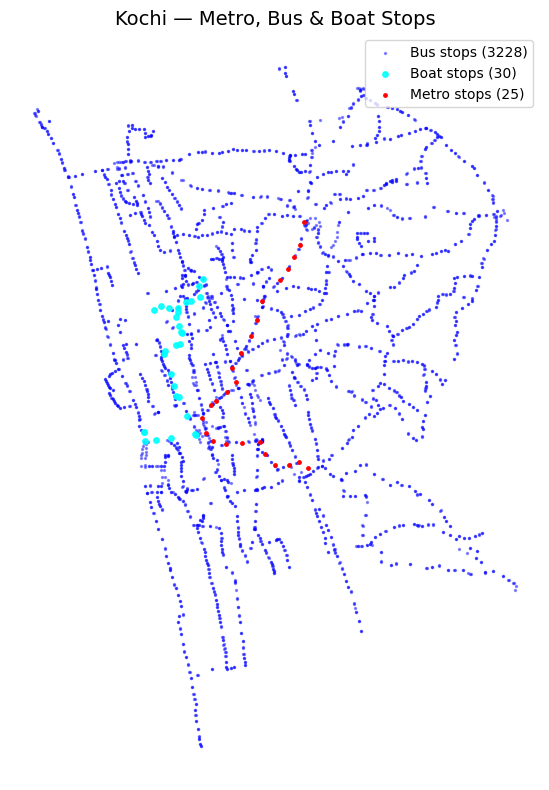

In [23]:
# --- Quick sanity check: plot all three layers together ---
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot in order: bus first (bottom), then boat, then metro on top
bus_gdf.plot(ax=ax, color='blue', markersize=2, alpha=0.4, label=f'Bus stops ({len(bus_gdf)})')
boat_gdf.plot(ax=ax, color='cyan', markersize=15, alpha=0.9, label=f'Boat stops ({len(boat_gdf)})')
gdf.plot(ax=ax, color='red', markersize=6, alpha=1.0, label=f'Metro stops ({len(gdf)})', zorder=5)

ax.set_title('Kochi — Metro, Bus & Boat Stops', fontsize=14)
ax.legend(loc='upper right')
ax.axis('off')
plt.tight_layout()
plt.savefig('output/all_stops_overview.png', dpi=150)
plt.show()


In [25]:
# ============================================================
# STEP C: 500m Buffer Analysis — Last-Mile Connectivity
# ============================================================

# --- Project to meters (EPSG:32643 = UTM Zone 43N, covers Kerala) ---
metro_proj = gdf.to_crs('EPSG:32643')
bus_proj   = bus_gdf.to_crs('EPSG:32643')
boat_proj  = boat_gdf.to_crs('EPSG:32643')

# --- Create 500m buffer around each metro stop ---
metro_proj['buffer_500m'] = metro_proj.geometry.buffer(500)

# --- Count bus stops within each metro stop's buffer ---
metro_buffers = metro_proj.set_geometry('buffer_500m')

bus_counts = []
boat_counts = []

for _, metro_row in metro_buffers.iterrows():
    bus_within  = bus_proj[bus_proj.geometry.within(metro_row['buffer_500m'])]
    boat_within = boat_proj[boat_proj.geometry.within(metro_row['buffer_500m'])]
    bus_counts.append(len(bus_within))
    boat_counts.append(len(boat_within))

metro_proj['bus_stops_nearby']  = bus_counts
metro_proj['boat_stops_nearby'] = boat_counts
metro_proj['total_connections'] = metro_proj['bus_stops_nearby'] + metro_proj['boat_stops_nearby']

# --- Connectivity classification ---
def classify_connectivity(n):
    if n >= 15:
        return 'Well Connected'
    elif n >= 5:
        return 'Moderately Connected'
    else:
        return 'Poorly Connected'

metro_proj['connectivity'] = metro_proj['total_connections'].apply(classify_connectivity)

print("Connectivity per metro stop:")
display(metro_proj[['stop_name', 'bus_stops_nearby', 'boat_stops_nearby', 
                     'total_connections', 'connectivity']]
        .sort_values('total_connections', ascending=False))

print("\nConnectivity distribution:")
print(metro_proj['connectivity'].value_counts())


Connectivity per metro stop:


,stop_name,bus_stops_nearby,boat_stops_nearby,total_connections,connectivity
19,Vyttila,20,0,20,Well Connected
8,Edapally,14,0,14,Moderately Connected
5,Kalamassery,13,0,13,Moderately Connected
12,Kaloor,13,0,13,Moderately Connected
15,Maharajas College,11,0,11,Moderately Connected
14,MG Road,10,0,10,Moderately Connected
0,Aluva,10,0,10,Moderately Connected
11,JLN Stadium,9,0,9,Moderately Connected
13,Town Hall,9,0,9,Moderately Connected
17,Kadavanthra,9,0,9,Moderately Connected



Connectivity distribution:
connectivity
Moderately Connected    19
Poorly Connected         5
Well Connected           1
Name: count, dtype: int64


In [26]:
# ============================================================
# STEP D: Recommendation Analysis for Poorly Connected Stops
# ============================================================

poorly_connected = metro_proj[metro_proj['connectivity'] == 'Poorly Connected'].copy()

print("=== POORLY CONNECTED METRO STOPS ===\n")
for _, row in poorly_connected.iterrows():
    print(f"🔴 {row['stop_name']}")
    print(f"   Bus stops within 500m : {row['bus_stops_nearby']}")
    print(f"   Boat stops within 500m: {row['boat_stops_nearby']}")
    print(f"   Coordinates           : {row['stop_lat']:.4f}, {row['stop_lon']:.4f}")
    print()

# --- Find nearest bus stops to each poorly connected metro stop ---
from shapely.ops import nearest_points

print("=== NEAREST BUS STOP TO EACH POORLY CONNECTED METRO STOP ===\n")
for _, metro_row in poorly_connected.iterrows():
    distances = bus_proj.geometry.distance(metro_row.geometry)
    nearest_idx = distances.idxmin()
    nearest_stop = bus_proj.loc[nearest_idx]
    nearest_dist = distances.min()
    print(f"🔴 {metro_row['stop_name']}")
    print(f"   Nearest bus stop : {nearest_stop['stop_name']}")
    print(f"   Distance         : {nearest_dist:.0f} metres")
    if nearest_dist <= 500:
        print(f"   Status           : ✅ Within 500m but low density")
    elif nearest_dist <= 1000:
        print(f"   Status           : ⚠️  Within 1km — feeder bus viable")
    else:
        print(f"   Status           : ❌ Over 1km — needs new route")
    print()

# --- Extend buffer to 1km and recheck ---
metro_proj['buffer_1km'] = metro_proj.geometry.buffer(1000)
metro_1km = metro_proj.set_geometry('buffer_1km')

print("=== BUS STOPS WITHIN 1KM (extended buffer) ===\n")
for _, row in metro_1km[metro_1km['connectivity'] == 'Poorly Connected'].iterrows():
    bus_within_1km = bus_proj[bus_proj.geometry.within(row['buffer_1km'])]
    print(f"🔴 {row['stop_name']}")
    print(f"   Bus stops within 500m : {row['bus_stops_nearby']}")
    print(f"   Bus stops within 1km  : {len(bus_within_1km)}")
    gap = len(bus_within_1km) - row['bus_stops_nearby']
    print(f"   Stops in 500m–1km gap : {gap} → these are reachable with a short feeder")
    print()

=== POORLY CONNECTED METRO STOPS ===

🔴 Companypady
   Bus stops within 500m : 2
   Boat stops within 500m: 0
   Coordinates           : 10.0873, 76.3428

🔴 Ambattukavu
   Bus stops within 500m : 2
   Boat stops within 500m: 0
   Coordinates           : 10.0793, 76.3389

🔴 Muttom
   Bus stops within 500m : 4
   Boat stops within 500m: 0
   Coordinates           : 10.0727, 76.3336

🔴 Pathadipalam
   Bus stops within 500m : 4
   Boat stops within 500m: 0
   Coordinates           : 10.0361, 76.3144

🔴 SN Junction
   Bus stops within 500m : 4
   Boat stops within 500m: 0
   Coordinates           : 9.9548, 76.3459

=== NEAREST BUS STOP TO EACH POORLY CONNECTED METRO STOP ===

🔴 Companypady
   Nearest bus stop : Companypady
   Distance         : 17 metres
   Status           : ✅ Within 500m but low density

🔴 Ambattukavu
   Nearest bus stop : Ambattukavu
   Distance         : 156 metres
   Status           : ✅ Within 500m but low density

🔴 Muttom
   Nearest bus stop : Muttom
   Distance    

In [27]:
# ============================================================
# STEP E: Final Connectivity Map with Recommendations
# ============================================================
import folium
from folium.plugins import MiniMap

connectivity_colors = {
    'Well Connected':       'green',
    'Moderately Connected': 'orange',
    'Poorly Connected':     'red'
}

# --- Convert back to WGS84 for folium ---
metro_wgs = metro_proj.to_crs('EPSG:4326')
bus_wgs   = bus_proj.to_crs('EPSG:4326')
boat_wgs  = boat_proj.to_crs('EPSG:4326')

# --- Base map ---
m2 = folium.Map(location=[10.02, 76.31], zoom_start=12, tiles='CartoDB positron')

# --- Bus stops (small dots) ---
for _, row in bus_wgs.iterrows():
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=3,
        color='blue',
        fill=True,
        fill_opacity=0.3,
        tooltip=row['stop_name']
    ).add_to(m2)

# --- Boat stops ---
for _, row in boat_wgs.iterrows():
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=6,
        color='cyan',
        fill=True,
        fill_opacity=0.8,
        tooltip=f"🚢 {row['stop_name']}"
    ).add_to(m2)

# --- Metro stops colored by connectivity ---
for _, row in metro_wgs.iterrows():
    color = connectivity_colors[row['connectivity']]
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=12,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.9,
        popup=folium.Popup(
            f"""
            <b>{row['stop_name']}</b><br>
            Bus stops (500m): {row['bus_stops_nearby']}<br>
            Boat stops (500m): {row['boat_stops_nearby']}<br>
            Total connections: {row['total_connections']}<br>
            Connectivity: {row['connectivity']}<br>
            Headway: {row['avg_headway_min']} min<br>
            Risk: {row['risk']}
            """,
            max_width=220
        ),
        tooltip=f"{row['stop_name']} — {row['connectivity']}"
    ).add_to(m2)

# --- Draw 1km buffer ring around poorly connected stops ---
poorly_wgs = metro_wgs[metro_wgs['connectivity'] == 'Poorly Connected']
for _, row in poorly_wgs.iterrows():
    folium.Circle(
        location=[row['stop_lat'], row['stop_lon']],
        radius=1000,
        color='red',
        fill=False,
        weight=1.5,
        dash_array='5',
        tooltip=f"{row['stop_name']} — 1km feeder zone"
    ).add_to(m2)

# --- Metro line ---
line_coords = metro_wgs.sort_values('stop_id')[['stop_lat', 'stop_lon']].values.tolist()
folium.PolyLine(
    locations=line_coords,
    color='black',
    weight=3,
    opacity=0.6,
    tooltip='KMRL Metro Line'
).add_to(m2)

# --- Minimap ---
MiniMap(
    tile_layer='CartoDB positron',
    position='bottomright',
    width=150, height=150,
    zoom_level_offset=-7,
    toggle_display=True
).add_to(m2)

# --- Legend ---
legend_html = """
<div style="position: fixed; bottom: 40px; left: 40px; z-index: 1000;
     background-color: white; padding: 12px 16px; border-radius: 8px;
     border: 1px solid #ccc; font-family: Arial; font-size: 13px;">
  <b>Last-Mile Connectivity</b><br>
  <i style="background:green;width:12px;height:12px;display:inline-block;border-radius:50%;margin-right:6px;"></i> Well Connected (≥15 bus stops)<br>
  <i style="background:orange;width:12px;height:12px;display:inline-block;border-radius:50%;margin-right:6px;"></i> Moderately Connected (5–14)<br>
  <i style="background:red;width:12px;height:12px;display:inline-block;border-radius:50%;margin-right:6px;"></i> Poorly Connected (&lt;5)<br>
  <i style="background:blue;width:12px;height:12px;display:inline-block;border-radius:50%;margin-right:6px;opacity:0.4"></i> Bus stops<br>
  <i style="background:cyan;width:12px;height:12px;display:inline-block;border-radius:50%;margin-right:6px;"></i> Boat stops<br>
  <br>
  <small>Dashed circle = 1km feeder zone</small><br>
  <small>Source: KMRL + Jungle Bus GTFS</small>
</div>
"""
m2.get_root().html.add_child(folium.Element(legend_html))

# --- Save ---
m2.save('output/kochi_connectivity_map.html')
print("Map saved to output/kochi_connectivity_map.html")
m2


Map saved to output/kochi_connectivity_map.html
